In [1]:
import matplotlib as plt
import matplotlib.pyplot as plt
#import matplotlib.cm as cm

import numpy as np
import pandas as pd
import random
import cv2
from matplotlib import figure
from tqdm import trange
#import scipy.special
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

from scipy.special import comb

import pylab
# Рисуем графики не создавая новых окон
%matplotlib inline


Научиться генерировать случайные кривые для того, чтобы потом по ним строить стимулы для пользователей.

План примерно такой:
1. Ознакомиться с классом кривых Безье, например тут: https://habr.com/ru/post/344814/ .Посмотреть, есть ли подобные способы описания путей с помощью кривых других классов - сравнить.

2. Научиться генерировать файлы стандартного формата, например SVG с описанием маршрутов на основе последовательностей кривых, которые выбираются из некоторого случайного множества. Описать параметры для распределений. Отображать последовательности точек вдоль этих маршрутов.

3. Сгенерировать точки вокруг такой кривой со случайным отклонением от истины и подумать, что нужно знать (из скольких участков состоит, какого каждый участок порядка, что-то еще?), чтобы решить обратную задачу - восстановить параметры кривой, зная данные точки.


##### Литература
1.Example-Based Curve Generation (генерация последовательности кривых, похожих на деревья) http://www.cs.unc.edu/techreports/09-010.pdf

2.A smooth tool path generation and real-time interpolation algorithm bazed on B-spline curves https://www.researchgate.net/publication/322598855_A_smooth_tool_path_generation_and_real-time_interpolation_algorithm_based_on_B-spline_curves

3.A Primer on Bézier Curves https://pomax.github.io/bezierinfo/

4.Python implementation of Algorithm for Automatically Fitting Digitized Curves by Philip J. Schneider "Graphics Gems", Academic Press, 1990 https://github.com/volkerp/fitCurves/blob/master/fitCurves.py

5.Use a method of least squares to find a 'best bezier fit' for a hand drawn arc. https://nbviewer.jupyter.org/gist/anonymous/5688579

6.Реализована модель движения с помощью кривых безье. По трем точкам… https://github.com/jimmbraddock/atn-python-modeling/commit/dfd2f637f76f96daf02a1f0f91c479e30df28374

7.DRAWING A CONTINUOUS BEZIER CURVE https://www.algosome.com/articles/continuous-bezier-curve-line.html

8.Data Fitting on Manifolds with Composite Bézier-Like Curves and Blended Cubic Splines https://perso.uclouvain.be/pygousenbourger/pdf/jmiv2018.pdf

9.A novel generalization of Bézier curve and surface https://www.sciencedirect.com/science/article/pii/S0377042707003482

10.Bezier Curve Based Path Planning in a Dynamic Field using Modified Genetic Algorithm https://www.sciencedirect.com/science/article/abs/pii/S1877750317308906

11.Optimizing robot path in dynamic environments using Genetic Algorithm and Bezier Curve https://pdfs.semanticscholar.org/2e0b/8a2b2580a48dd4ddd8083373fbf781fba39d.pdf

12.Genetic Algorithm-Based Least Square Fitting of B-Spline and Bézier Curves
http://crad.ict.ac.cn/EN/abstract/abstract779.shtml

13.A tensor optimization algorithm for Bézier Shape Deformation https://www.sciencedirect.com/science/article/pii/S0377042715001053

14.BézierGAN: Automatic Generation of Smooth Curves from Interpretable Low-Dimensional Parameters https://arxiv.org/abs/1808.08871
15.

In [2]:
# рабочий вариант
length_path=10
borders=1000
def control_points_for_bezier_curve(length_path, borders):
    wx=[]
    wy=[]
    #curves_degrees=[]
    l=0
    z=0
    k=length_path/2
    p=borders/k
    for i in range(length_path):
        x=[]
        y=[]
        if i<k:
            n=random.choice([1, 2, 3])
            #curves_degrees.append(n)
            for h in range(n+1):
                x.append(random.randint(z, (borders/k)*(i+1)))
                y.append(random.randint(borders/2, borders))
                h+=1
            z+=borders/k
            i+=1
        else:
            n=random.choice([1,2,3])
            #curves_degrees.append(n)
            for h in range(n+1):
                x.append(random.randint(borders-p, borders-l))
                y.append(random.randint(1,borders/2))
                h+=1
            p+=borders/k
            l+=borders/k
            i+=1
        
        wx.append(x)
        wy.append(y)
    return wx, wy #curves_degrees

In [3]:
#Зададим функцию кривой Безье

def bezier_curve(wx, wy, j, steps,borders,start_point):
    x=[]
    y=[]
    times=np.linspace(0,1,steps)
    if len(wx[j])-1==1:
        if start_point!=[]:
            [wx[j][0], wy[j][0]]=start_point
            #print(w)
        for time in times:
            x.append(wx[j][0]*(1-time) + wx[j][1]*time)
            y.append(wy[j][0]*(1-time) + wy[j][1]*time)
        return x, y
    elif len(wx[j])-1==2:
        if start_point!=[]:
            [wx[j][0], wy[j][0]]=start_point
            #print(w)
        
        for time in times:
            x.append(wx[j][0]*(1-time)**2 + wx[j][1]*2*(1-time)*time + wx[j][2]*time**2)
            y.append(wy[j][0]*(1-time)**2 + wy[j][1]*2*(1-time)*time + wy[j][2]*time**2)
        return x, y
    elif len(wx[j])-1==3:
        if start_point!=[]:
            [wx[j][0], wy[j][0]]=start_point
            #print(w)
        for time in times:
            x.append(wx[j][0]*(1-time)**3 + 3*wx[j][1]*(1-time)**2*time + 3*wx[j][2]*(1-time)*time**2 + wx[j][3]*time**3)
            y.append(wy[j][0]*(1-time)**3 + 3*wy[j][1]*(1-time)**2*time + 3*wy[j][2]*(1-time)*time**2 + wy[j][3]*time**3)
        return x, y
    
    

In [4]:
#рабочий вариант 29.05.2020


def generate_bezier_curves(borders,num_samples,length_path, random_state=42):
    curve_points_x=[]
    curve_points_y=[]
    control_points=[]
    for i in trange(num_samples):
        x2 = [] #х координаты для кривых Безье
        y2 = [] #у координаты для кривых Безье
        xpoints = [] #х координаты контрольных точек кривых Безье
        ypoints = [] #у координаты контрольных точек кривых Безье
        steps=100
        image='img'+str(i)
        #end_point=[]
        finish_point=[]
        wx, wy = control_points_for_bezier_curve(length_path=10, borders=1000) #координаты для кривых Безье
        for j in range(length_path):
            if j==0:
                finish_point=[wx[j][0], wy[j][0]]
                
            if j==length_path-1:
                [wx[j][-1], wy[j][-1]]=finish_point
        
            #start_point=end_point
            x1, y1 = bezier_curve(wx=wx, wy=wy, j=j, borders=1000, steps=100, start_point=[])
            #start_point=end_point
            x2+=x1
            y2+=y1
            #end_point=[wx[j][-1], wy[j][-1]]
            xpoints+=wx[j]
            ypoints+=wy[j]
            j+=1
        control_points.append([xpoints,ypoints])  
        curve_points_x.append(x2)
        curve_points_y.append(y2)
        plt.figure()
        plt.plot(x2,y2,'b')
        plt.plot(xpoints, ypoints,'ro')
        #plt.savefig('%s.svg' % image, transparent=True, format="svg")
    return np.array(curve_points_x), np.array(curve_points_y), np.array(control_points)

In [232]:
# Переводим кривые из декартовых (х, у) в однородные координаты (х, у, 1)

def preparation_curves(curve_xpoints,curve_ypoints): 
    curve_path=[]
    for i in range(num_samples):
        curve=[]
        for j in range(curve_xpoints.shape[1]):
            l=np.column_stack((curve_xpoints[i][j],curve_ypoints[i][j]))
            curve+=np.column_stack((l, np.ones(l.shape[0]))).tolist()
        curve_path.append(curve) 
    return np.array(curve_path)


In [452]:
#Проекции

#1 оригинальная кривая
def identity(curve):
    Id=np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
    return curve@Id

#2 вращение на 60 градусов
def rotation_60(curve):
    angle = np.radians(60)
    center=borders//2
    Rt_1 = np.array([
    [np.cos(angle), np.sin(angle), (1-np.cos(angle))*center-np.sin(angle)*center],
    [-np.sin(angle), np.cos(angle), np.sin(angle)*center+(1-np.cos(angle)*center)],
    [0, 0, 1]])
    return curve@Rt_1

#3 вращение на 45 градусов
def rotation_45(curve):
    angle = np.radians(45)
    center=borders//2
    Rt_2= np.array([
    [np.cos(angle), np.sin(angle), (1-np.cos(angle))*center-np.sin(angle)*center],
    [-np.sin(angle), np.cos(angle), np.sin(angle)*center+(1-np.cos(angle)*center)],
    [0, 0, 1]])
    return curve@Rt_2

#4 перемещение
def translation(curve):
    tx, ty = np.array((borders // 2, borders // 2))
    T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]])
    return curve@T

#5 растяжение в 2 раза
def scale(curve):
    scale = 2
    S = np.array([
    [scale, 0, 0],
    [0, scale, 0],
    [0, 0, 1]])
    return curve@S

#6 отражение относительно оси x
def reflection_x(curve): 
    Rx = np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]])
    return curve@Rx

#7 отражение относительно оси y 
def reflection_y(curve):
    Ry = np.array([
        [-1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
    return curve@Ry

#8 горизонтальное сжатие
def horizontal_shear(curve):
    shear=0.5
    Hs = np.array([
    [1, shear, 0],
    [0, 1, 0],
    [0, 0, 1]])
    return curve@Hs

#9 вертикальное сжатие
def vertical_shear(curve):
    shear=0.5
    Vs = np.array([
    [1, 0, 0],
    [shear, 1, 0],
    [0, 0, 1]])
    return curve@Vs

#10 перспективное преобразование
def perspective_projection(curve):
    src_points = np.float32([[0,0], [borders,0], [int(0.33*borders),borders], [int(0.66*borders),borders]])
    dst_points = np.float32([[0,0], [borders,0], [0,borders], [borders,borders]])
    H = cv2.getPerspectiveTransform(src_points, dst_points)
    return curve@H

In [453]:
def control_points_to_dataframe(curve_control_points):
    control_xpoints=[]
    control_ypoints=[]
    for i in range(num_samples):
        xpoints=[]
        ypoints=[]
        for j in range(1000):
            xpoints.append(curve_control_points[i][0])
            ypoints.append(curve_control_points[i][1])
        control_xpoints+=xpoints
        control_ypoints+=ypoints
    return pd.DataFrame(data=control_xpoints), pd.DataFrame(data=control_ypoints)

In [454]:
# Проективные преобразования кривых

def projective_transformations(curve_path):
    curve_paths=[]
    U=np.array([[1,0],[0,1],[0,0]])
    
    for i in range(curve_path.shape[0]):
        curve1 = identity(curve_path[i])
        curve_paths.append(curve1@U.tolist())
        
        curve2 = rotation_60(curve_path[i])
        curve_paths.append(curve2@U.tolist())
        
        curve3 = rotation_45(curve_path[i])
        curve_paths.append(curve3@U.tolist())
        
        curve4 = translation(curve_path[i])
        curve_paths.append(curve4@U.tolist())
        
        curve5 = scale(curve_path[i])
        curve_paths.append(curve5@U.tolist())
        
        curve6 = reflection_x(curve_path[i])
        curve_paths.append(curve6@U.tolist())
        
        curve7 = reflection_y(curve_path[i])
        curve_paths.append(curve7@U.tolist())
        
        curve8 = horizontal_shear(curve_path[i])
        curve_paths.append(curve8@U.tolist())
        
        curve9 = vertical_shear(curve_path[i])
        curve_paths.append(curve9@U.tolist())
        
        curve10 = perspective_projection(curve_path[i])
        curve_paths.append(curve10@U.tolist())
        
        
    return curve_paths  #transformation_matrices, curve_paths

In [469]:
# Генерируем 100 случайных точек

def generate_random_points(num_samples, bezier_curve_paths, borders):
    x_random_points=[] #х координаты случайных точек 
    y_random_points=[] #у координаты случайных точек 
    string=[-4,-3,-2,-1,0,1,2,3,4] #разброс отступа от кривой
    for i in trange(len(bezier_curve_paths)):
        x_random=[]
        y_random=[]
        for j in range(100):
            xx_random=[]
            yy_random=[]
            a=0
            #генерируем 35 случайных точек с отступом по х координате от кривой
            for j in range(35):
                a=np.random.choice(len(bezier_curve_paths[i]))
                xx_random.append(bezier_curve_paths[i][a][0]+np.random.choice(string))
                yy_random.append(bezier_curve_paths[i][a][1])
            #генерируем 35 случайных точек с отступом по y координате от кривой                   
            for k in range(35):
                a=np.random.choice(len(bezier_curve_paths[i]))
                xx_random.append(bezier_curve_paths[i][a][1])
                yy_random.append(bezier_curve_paths[i][a][0]+np.random.choice(string))
            xx_random+=np.random.randint(1,borders+1,size=30).tolist() #генерируем выбросы - 30 точек
            yy_random+=np.random.randint(1,borders+1,size=30).tolist()
            x_random.append(xx_random)
            y_random.append(yy_random)
    
        x_random_points+=x_random
        y_random_points+=y_random
    return pd.DataFrame(data=x_random_points),  pd.DataFrame(data=y_random_points) #, y_random_points

In [463]:
def bezier_curve_paths_to_dataframe(bezier_curve_paths):
    xcurve_points=[]
    ycurve_points=[]
    for i in trange(len(bezier_curve_paths)):
        xcurve=[]
        ycurve=[]
        for k in range(100):
            xxcurve=[]
            yycurve=[]
            for j in range(len(bezier_curve_paths[i])):
                xxcurve.append(bezier_curve_paths[i][j][0])
                yycurve.append(bezier_curve_paths[i][j][1])
            xcurve.append(xxcurve)
            ycurve.append(yycurve)
            
        xcurve_points+=xcurve
        ycurve_points+=ycurve
    return pd.DataFrame(data=xcurve_points), pd.DataFrame(data=ycurve_points)

100%|██████████| 20/20 [00:00<00:00, 30.49it/s]


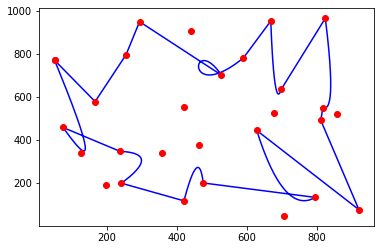

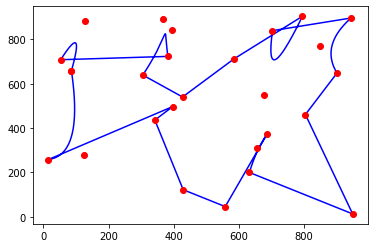

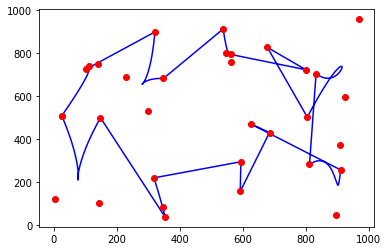

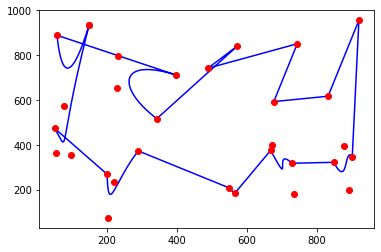

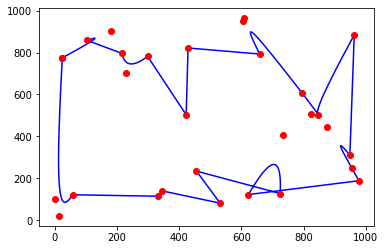

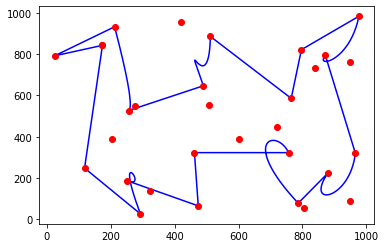

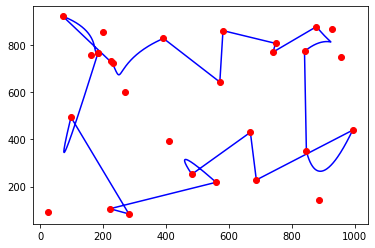

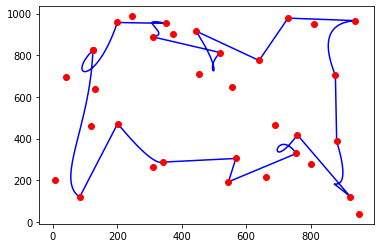

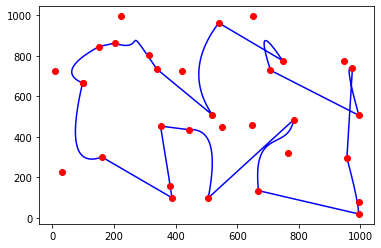

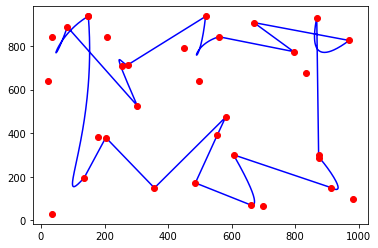

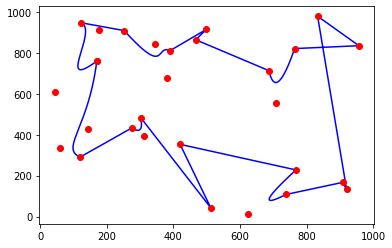

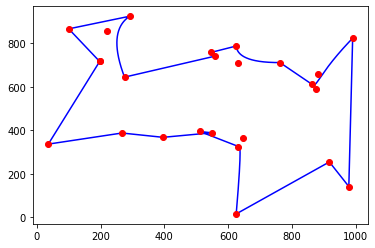

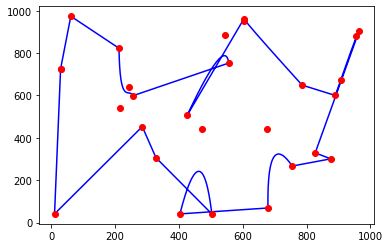

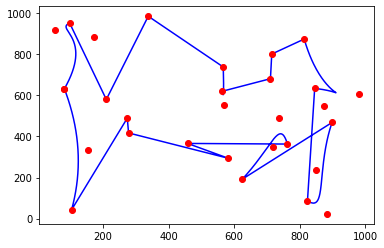

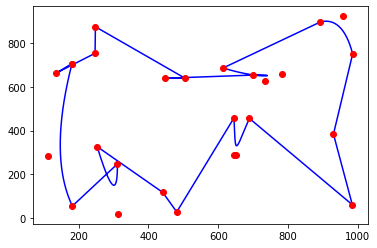

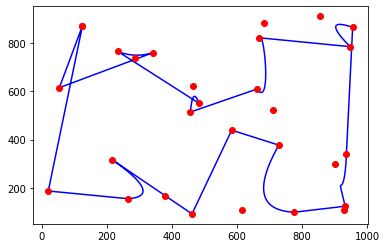

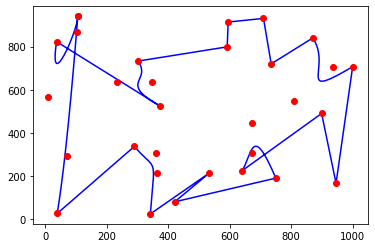

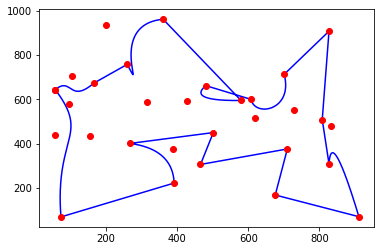

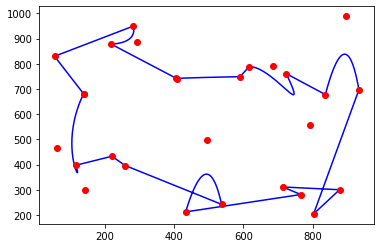

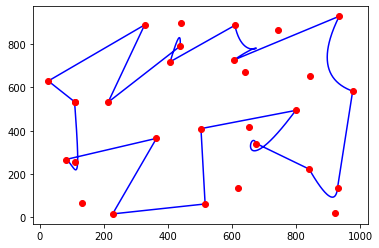

In [9]:
borders=2000
num_samples=20
length_path=10
curve_xpoints, curve_ypoints, curve_control_points = generate_bezier_curves(borders,num_samples,length_path)


In [ ]:
def generate_bezier_curves(borders,num_samples,length_path, random_state=42):
    curve_points_x=[]
    curve_points_y=[]
    control_points=[]
    
    for i in trange(num_samples):
        x2 = [] #х координаты для кривых Безье
        y2 = [] #у координаты для кривых Безье
        xpoints = [] #х координаты контрольных точек кривых Безье
        ypoints = [] #у координаты контрольных точек кривых Безье
        steps=100
        image='img'+str(i)
        #end_point=[]
        finish_point=[]
        wx, wy = control_points_for_bezier_curve(length_path, borders) #координаты для кривых Безье

        for j in range(length_path):
            if j==0:
                finish_point=[wx[j][0], wy[j][0]]
                
            if j==length_path-1:
                [wx[j][-1], wy[j][-1]]=finish_point
        
            x1, y1 = bezier_curve(wx, wy, j, borders, steps, start_point=[])
            x2+=x1
            y2+=y1
            xpoints+=wx[j]
            ypoints+=wy[j]
            j+=1
        control_points.append([xpoints,ypoints])  
        curve_points_x.append(x2)
        curve_points_y.append(y2)
        plt.figure()
        plt.plot(x2,y2,'b')
        plt.plot(xpoints, ypoints,'ro')
        #plt.savefig('%s.svg' % image, transparent=True, format="svg")
        plt.close()
    return np.array(curve_points_x), np.array(curve_points_y), np.array(control_points)

In [8]:
curve_xpoints.shape

(10, 1000)

In [ ]:
curve_path=preparation_curves(curve_xpoints,curve_ypoints)
bezier_curve_paths=projective_transformations(curve_path)
x_curve_bezier, y_curve_bezier = bezier_curve_paths_to_dataframe(bezier_curve_paths)
control_xpoints, control_ypoints = control_points_to_dataframe(curve_control_points)
x_random_points, y_random_points =generate_random_points(num_samples, bezier_curve_paths, borders)

In [422]:
num_samples=10
borders=1000
curve_path=preparation_curves(curve_xpoints,curve_ypoints)
bezier_curve_paths=projective_transformations(curve_path)
x_curve_bezier, y_curve_bezier = bezier_curve_paths_to_dataframe(bezier_curve_paths)
control_xpoints, control_ypoints = control_points_to_dataframe(curve_control_points)
x_random_points, y_random_points =generate_random_points(num_samples, bezier_curve_paths, borders)

100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


In [494]:
Y=[i for i in range(1,11) for j in range(100)]*num_samples
transformation_number=pd.DataFrame(data=Y, columns=['class'])

In [493]:
Bezier_curves=pd.concat([control_xpoints, control_ypoints, x_curve_bezier, y_curve_bezier, x_random_points, y_random_points,transformation_number], axis=1)
Bezier_curves

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,class
0,5,179,5,155,380,293,589,569,759,792,...,126,341,182,372,965,339,185,539,37,1
1,5,179,5,155,380,293,589,569,759,792,...,834,914,685,37,579,516,942,318,834,1
2,5,179,5,155,380,293,589,569,759,792,...,665,371,803,278,210,767,461,32,728,1
3,5,179,5,155,380,293,589,569,759,792,...,785,820,127,947,232,220,400,73,356,1
4,5,179,5,155,380,293,589,569,759,792,...,539,335,367,714,437,937,804,176,859,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,131,151,105,265,211,200,309,537,492,440,...,245,206,562,355,397,944,514,172,957,10
9996,131,151,105,265,211,200,309,537,492,440,...,916,584,682,83,434,205,489,191,565,10
9997,131,151,105,265,211,200,309,537,492,440,...,591,753,729,967,613,99,629,546,938,10
9998,131,151,105,265,211,200,309,537,492,440,...,878,588,99,484,706,925,770,746,465,10


In [495]:
Bezier_curves.fillna(0)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,class
0,5,179,5,155,380,293,589,569,759,792,...,126,341,182,372,965,339,185,539,37,1
1,5,179,5,155,380,293,589,569,759,792,...,834,914,685,37,579,516,942,318,834,1
2,5,179,5,155,380,293,589,569,759,792,...,665,371,803,278,210,767,461,32,728,1
3,5,179,5,155,380,293,589,569,759,792,...,785,820,127,947,232,220,400,73,356,1
4,5,179,5,155,380,293,589,569,759,792,...,539,335,367,714,437,937,804,176,859,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,131,151,105,265,211,200,309,537,492,440,...,245,206,562,355,397,944,514,172,957,10
9996,131,151,105,265,211,200,309,537,492,440,...,916,584,682,83,434,205,489,191,565,10
9997,131,151,105,265,211,200,309,537,492,440,...,591,753,729,967,613,99,629,546,938,10
9998,131,151,105,265,211,200,309,537,492,440,...,878,588,99,484,706,925,770,746,465,10


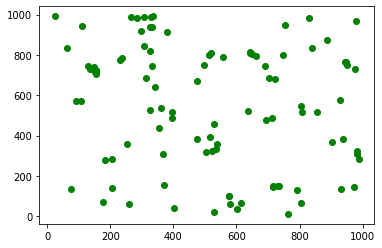

In [475]:
x_pts=[x_random_points[j][1] for j in range(x_random_points.shape[1])]
y_pts=[y_random_points[j][1] for j in range(y_random_points.shape[1])]
#plt.plot(u,r,'b')
plt.plot(x_pts,y_pts,'go')

In [ ]:
for i in range(10):
        plt.figure()
        plt.plot(xcurve_points[i*100],ycurve_points[i*100],'-r')
    #plt.subplots(nrows=2, ncols=5)

In [414]:
len(xcurve_points)

100

In [415]:
len(paths)

100

In [416]:
curve_xpoints.shape

(10, 1000)

In [417]:
curve_control_points.shape 

(10, 2)

In [203]:
#td=pd.DataFrame(data=np.hstack(paths))
#td
path=np.array(paths)
path.shape

(10, 1000, 2)

In [8]:
#len(a)
num_samples=10
l=0
curve_path=[]
for i in range(num_samples):
    curve=[]
    #print(len(a[i])-1)
    for j in range(m.shape[1]):
        l=np.column_stack((a[i][j],b[i][j]))
        #np.column_stack((l,))
        #print(l)
        curve+=np.column_stack((l, np.ones(l.shape[0]))).tolist()
        #print(l.shape)
        #curve_path.append()
    curve_path.append(curve)    
curve_path=np.array(curve_path)
print(curve_path.shape)

(10, 1000, 3)


[[ 1.0000000e+00 -3.3033033e-01  0.0000000e+00]
 [ 0.0000000e+00  3.3033033e-01  0.0000000e+00]
 [-0.0000000e+00 -6.7034001e-04  1.0000000e+00]]


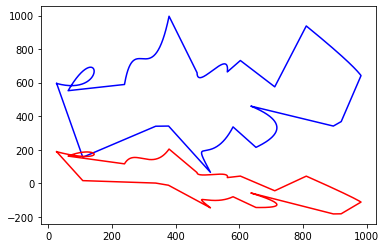

In [40]:
#(h, w) = image.shape[:2]
#center = (1000/ 2, 1000 / 2)
#src = np.array([[0,0],[1000,1000],[0,1000],[1000,0]],np.float32)
#dst = np.array([[0,0],[500,500],[0,500],[500,0]],np.float32)
img=np.array(curve_path[0],np.float32)
rows, cols = (1000,1000)
u=[img[x][0] for x in range(img.shape[0])]
r=[img[x][1] for x in range(img.shape[0])]
dst_points = np.float32([[0,0], [cols-1,0], [0,rows-1], [cols-1,rows-1]])
#print(src_points)
src_points = np.float32([[0,0], [cols-1,0], [int(0.33*cols),rows-1], [int(0.66*cols),rows-1]]) 
#print(dst_points)
projective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
#M=cv2.findHomography(src_points, dst_points)#print(projective_matrix)
angle = np.radians(90)
center=borders//2
Rt = np.array([
    [np.cos(angle), np.sin(angle), (1-np.cos(angle))*center-np.sin(angle)*center],
    [-np.sin(angle), np.cos(angle), np.sin(angle)*center+(1-np.cos(angle)*center)],
    [0, 0, 1]])
p=img@projective_matrix
p.shape
#projective_matrix=projective_matrix@np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
print(projective_matrix)
x=[p[x][0] for x in range(p.shape[0])]
y=[p[x][1] for x in range(p.shape[0])]
plt.plot(u,r,'b')
plt.plot(x,y,'-r')


[[ 1.0e+00 -3.3e-01  0.0e+00]
 [ 0.0e+00  3.3e-01  0.0e+00]
 [-0.0e+00 -6.7e-04  1.0e+00]]


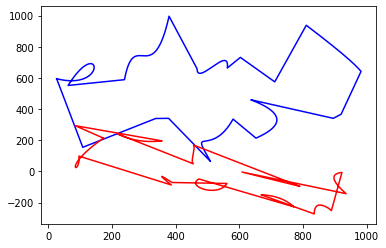

In [43]:
img=np.array(curve_path[0],np.float32)
borders=1000
src_points = np.float32([[0,0], [borders,0], [int(0.33*borders),1000], [int(0.66*borders),1000]])
dst_points = np.float32([[0,0], [borders,0], [0,borders], [borders,borders]])
H = cv2.getPerspectiveTransform(src_points, dst_points)
print(H)
p=curve@H
u=[img[x][0] for x in range(img.shape[0])]
r=[img[x][1] for x in range(img.shape[0])]
x=[p[x][0] for x in range(p.shape[0])]
y=[p[x][1] for x in range(p.shape[0])]
plt.plot(u,r,'b')
plt.plot(x,y,'r')

d = ½ w ctg (φ/2), В перспективных проекциях, как уже говорилось, проецирующие прямые пересекаются в «объективе» виртуальной камеры.

Поскольку экран ограничен, у перспективной проекции есть два важных параметра — фокусное расстояние (в «условных миллиметрах») и угол зрения (от 0 до 180°). Они взаимосвязаны: между углом зрения φ и фокусным расстоянием d соотношение

d = ½ w ctg (φ/2),
где w — ширина стандартного фотоматериала (36 мм). На старых трубчатых мониторах угол зрения ставят 90° или чуть меньше, современные (2014) 16:10 могут отобразить без дискомфорта до 120°.

In [ ]:
def persp_transformation(zfront, zback):
    a = (zfront+zback)/(zfront-zback)
    b = -2*(zfront*zback)/(zfront-zback)
    return np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, a, b],
                     [0, 0, -1, 0]])



def ortho_transformation(zfront, zback):
    # note: w component in the resulting vector will be (zback-zfront), not 1
    a = -(zfront + zback)
    b = -(zfront - zback)
    return np.array([[2, 0, 0, 0],
                     [0, 2, 0, 0],
                     [0, 0, -2, 0],
                     [0, 0, a, b]])

height, width = image.shape[:2]
tx, ty = np.array((width // 2, height // 2))
angle = np.radians(45)
scale = 2.0
R = np.array([
    [np.cos(angle), np.sin(angle), 0],
    [-np.sin(angle), np.cos(angle), 0],
    [0, 0, 1]
])
T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])
S = np.array([
    [scale, 0, 0],
    [0, scale, 0],
    [0, 0, 1]
])
A = T @ R @ S @ np.linalg.inv(T)